References:
- [Probabilistic Programming & Bayesian Methods for Hackers](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers?tab=readme-ov-file)
- [Statistical Rethinking 2023](https://github.com/dustinstansbury/statistical-rethinking-2023)
- [Danielle Navarro's Blog 'The Metropolis-Hastings algorithm'](https://blog.djnavarro.net/posts/2023-04-12_metropolis-hastings/#the-problem)
- [Martin Osvaldo A, Kumar Ravin; Lao Junpeng Bayesian Modeling and Computation in Python Boca Ratón, 2021. ISBN 978-0-367-89436-8](https://bayesiancomputationbook.com/welcome.html)



`pm.Exponential()` variables are treated by the back end as random number generators.

## Priors
### Beta Distribution
Used to model Bernoulli, Binomial, or Geometric distributions.

Bounded between [0,1]. 

$ Beta(1,1) $ is a uniform distribution. 

### Gamma Distribution
Use Case: Rate parameters in Poisson or Exponential distributions; precision (inverse variance) in Normal distributions.

## Bayesian Bandits
An approximate solution to the infamous [Multi-Armed Bandit problem](https://en.wikipedia.org/wiki/Multi-armed_bandit) can be found with Bayesian methods. In this example, we have 3 slot machines (bandits) that are win/lose for simplificiation and we don't know the probability of win/losing initially. We start with a $Beta(1,1)$ prior and sample from them to update our beliefs about which slot machine gives us the best chance of winning.

The code below samples every bandit each trail. In the real solution, only one bandit is sampled per trial. 

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az

%config InlineBackend.figure_formats = ['svg']

plt.rcParams['figure.figsize'] = (12, 4)
rng = np.random.default_rng(seed=42)
n_trials = [0, 1, 2, 3, 4, 5, 8, 15, 50, 500]
n_simulations = 10000

slot_machine_1 = rng.binomial(n=1, p=0.3, size=n_simulations)
slot_machine_2 = rng.binomial(n=1, p=0.25, size=n_simulations)
slot_machine_3 = rng.binomial(n=1, p=0.1, size=n_simulations)
sim_list = [slot_machine_1, slot_machine_2, slot_machine_3]

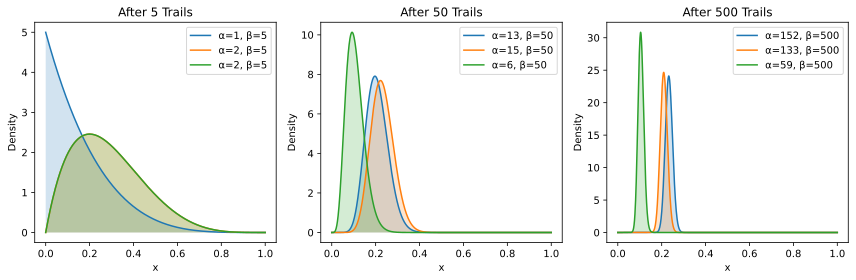

In [2]:
n_trials = [5, 50, 500]
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
x = np.linspace(0, 1, 1000)

for i, trails in enumerate(n_trials):
    for sim in sim_list:
        wins = rng.choice(sim, size=trails).sum()
        a = wins + 1
        b = trails
        y = stats.beta.pdf(x, a, b)
        axs[i].plot(x, y, label=f'α={a}, β={b}')
        axs[i].fill_between(x, y, alpha=0.2)
        axs[i].set_title(f'After {trails} Trails')
        axs[i].set_xlabel('x')
        axs[i].set_ylabel('Density')
        axs[i].legend()

plt.tight_layout()
plt.show()

## Detecting Change Over Time
We have data containing the count of events that occured on a given day. We want to determine if there has been an increase in events.

We start with the prior believe that the events are exponentially distributed with a mean that is equal to the observed data average. We also define a variable, $\tau$, that is uniformly distributed across each time step in the dataset. Then we sample from the observed data and update our believes and analyze the resulting distributions.  

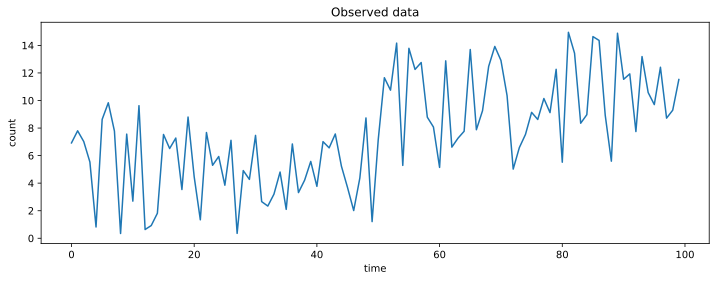

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_1, lambda_2]
>Metropolis: [tau]


Output()

Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 31 seconds.


In [3]:
data = np.concatenate([
    rng.uniform(low=0, high=10, size=50),
    rng.uniform(low=5, high=15, size=50)
])

n = len(data)
plt.plot(np.arange(n), data)
plt.title('Observed data')
plt.ylabel('count')
plt.xlabel('time')
plt.show()

with pm.Model() as model:
    alpha = 1.0 / data.mean()
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    tau = pm.DiscreteUniform("tau", lower=0, upper=n - 1)

    idx = np.arange(n)
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)

    observation = pm.Poisson("obs", lambda_, observed=data)

    step = pm.NUTS()
    trace = pm.sample(10000, tune=5000, step=step, return_inferencedata=False)

lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

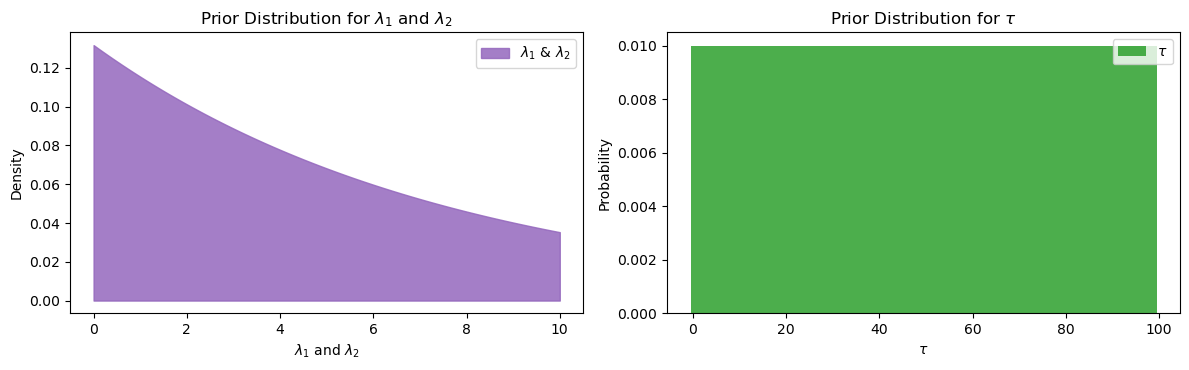

In [5]:
# Create a new figure for prior distributions
fig_prior, axes_prior = plt.subplots(1, 2)

x_values = np.linspace(0, 10, 100)
prior_lambda_1 = (alpha * np.exp(-alpha * x_values))  # Prior distribution for lambda_1
prior_lambda_2 = (alpha * np.exp(-alpha * x_values))  # Prior distribution for lambda_2

# Plot prior for lambda_1
axes_prior[0].fill_between(x_values, prior_lambda_1, color="C4", alpha=0.85, label='$\\lambda_1$ & $\\lambda_2$')
axes_prior[0].set_title("Prior Distribution for $\\lambda_1$ and $\\lambda_2$")
axes_prior[0].set_xlabel("$\\lambda_1$ and $\\lambda_2$")
axes_prior[0].legend(loc="upper right")
axes_prior[0].set_ylabel("Density")

# Plot prior for tau
tau_x_values = np.arange(0, n)  # Discrete values for tau
prior_tau = np.ones_like(tau_x_values) / len(tau_x_values)  # Uniform distribution
axes_prior[1].bar(tau_x_values, prior_tau, width=1, color="C2", alpha=0.85, label='$\\tau$')
axes_prior[1].set_title("Prior Distribution for $\\tau$")
axes_prior[1].set_xlabel("$\\tau$")
axes_prior[1].set_ylabel("Probability")
axes_prior[1].legend(loc="upper right")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

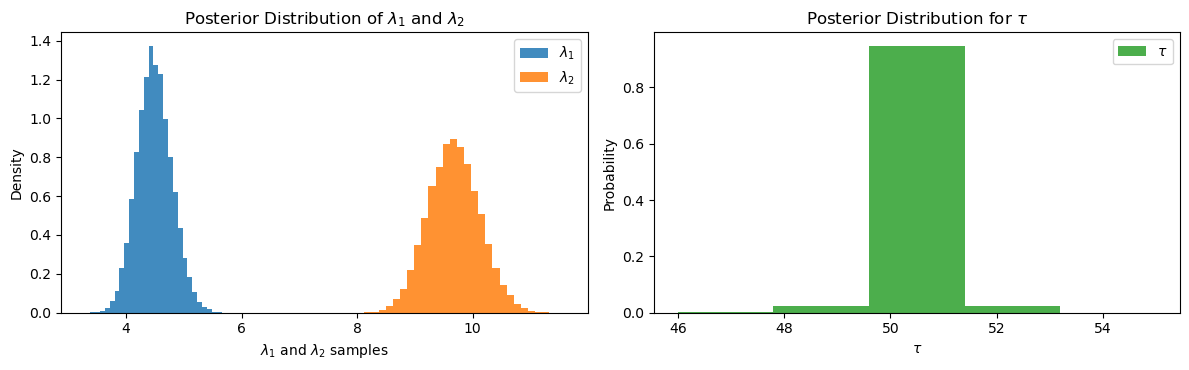

In [6]:
fig, axes = plt.subplots(1, 2)

axes[0].hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85, color="C0", density=True, label='$\\lambda_1$')
axes[0].hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85, color="C1", density=True, label='$\\lambda_2$')
axes[0].set_xlabel("$\\lambda_1$ and $\\lambda_2$ samples")
axes[0].set_ylabel("Density")
axes[0].legend(loc="upper right")
axes[0].set_title("Posterior Distribution of $\\lambda_1$ and $\\lambda_2$")

weights = np.ones_like(tau_samples) / tau_samples.shape[0]
axes[1].hist(tau_samples, bins=5, alpha=0.85, color="C2", weights=weights, label='$\\tau$')
axes[1].set_xlabel(r"$\tau$")
axes[1].set_ylabel("Probability")
axes[1].legend(loc="upper right")
axes[1].set_title("Posterior Distribution for $\\tau$")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Time Series Forecasting

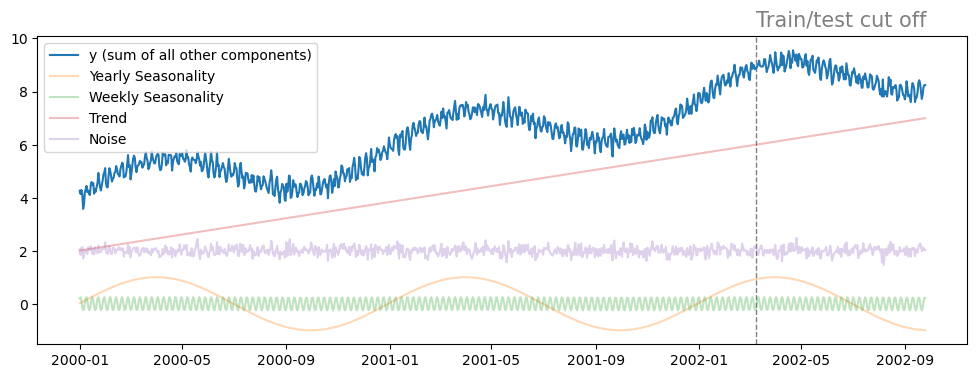

In [31]:
rng = np.random.default_rng(42)
t = np.arange(1, 1000)
df = pd.DataFrame({
    'yearly_seasonality': np.sin(2*np.pi*t/ 365),
    'weekly_seasonality': 0.25*np.sin(2*np.pi*t / 365*52),
    'trend': 2+t*.005,
    'noise': rng.normal(2, scale=0.15, size=len(t)),
},
    index=pd.date_range(start='2000-01-01', periods=len(t), freq='D')
)
df['total'] = df['yearly_seasonality'] + df['weekly_seasonality'] + df['trend'] + df['noise']

train_cutoff = int(len(df) * 0.8)
target_df = df.loc[:, 'total']
train_df, test_df = target_df.iloc[:train_cutoff], target_df.iloc[train_cutoff:]

def plot_df(df, train_df):
    plt.axvline(x=train_df.index[-1], color='gray', linestyle='--', linewidth=1)
    plt.text(train_df.index[-1], train_df.max()+2, 'Train/test cut off',
        color='gray', fontsize=15, va='top', ha='left')

    plt.plot(df['total'], label='y (sum of all other components)')
    plt.plot(df['yearly_seasonality'], label='Yearly Seasonality', alpha=.3)
    plt.plot(df['weekly_seasonality'], label='Weekly Seasonality', alpha=.3)
    plt.plot(df['trend'], label='Trend', alpha=.3)
    plt.plot(df['noise'], label='Noise', alpha=.3)
    plt.legend()
    plt.show()

plot_df(df, train_df)

In [8]:
# t = np.arange(1, 100)
# df = pd.DataFrame({
#     'yearly_seasonality': np.sin(2 * np.pi * t / 12),
#     # 'weekly_seasonality': 0.25*np.sin(2*np.pi*t / 12*52),
#     'trend': 3+t*0.005,
#     'noise': rng.normal(2, scale=0.15, size=len(t)),
# },
#     index=pd.date_range(start='2000-01-01', periods=len(t), freq='ME')
# )
# # df['total'] = df['yearly_seasonality'] + df['weekly_seasonality'] + df['trend'] + df['noise']
# df['total'] = df['yearly_seasonality'] + df['trend'] + df['noise']

# train_cutoff = int(len(df) * 0.8)
# target_df = df.loc[:, 'total']
# train_df, test_df = target_df.iloc[:train_cutoff], target_df.iloc[train_cutoff:]

# plot_df(df, train_df)

The Bayesian model includes three components:
- Trend: a linear function with an intercept and slope.
- Seasonality: a sinusoidal function with amplitude, frequency, and phase.
- Noise: gaussian noise with an unknown standard deviation.

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [ ]:
y_test = test_df.values
y_train = train_df.values
t_train = t[:len(train_df)]

with pm.Model() as model:
    # Priors for the trend
    intercept = pm.Normal('intercept', mu=5, sigma=10)
    slope = pm.Normal('slope', mu=0, sigma=1)
    
    # Priors for the seasonality
    amplitude = pm.HalfNormal('amplitude', sigma=10)
    # Frequency as a fraction of the sampling rate
    # monthly seasonality implies frequency around 1/12 ≈ 0.083
    frequency = pm.Uniform('frequency', lower=0.05, upper=.1)  
    phase = pm.Uniform('phase', lower=0, upper=2 * np.pi)
    
    # Prior for the noise
    sigma = pm.HalfNormal('sigma', sigma=1)
    
    # Expected value of the time series
    mu = intercept + \
        slope * t_train + \
        amplitude * pm.math.sin(2 * np.pi * frequency * t_train + phase)
    
    # Likelihood (sampling distribution) of observations
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y_train)

- `tune`: Number of tuning (burn-in) steps.
- `target_accept`: Adjusts the step size for better convergence; higher values reduce the chance of divergent samples.

In [10]:
with model:
    trace = pm.sample(
        draws=2000,
        tune=1000,
        nuts={'target_accept': 0.99, 'max_treedepth': 15},
        return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, amplitude, frequency, phase, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 384 seconds.


In [11]:
# az.plot_energy(trace)
# plt.show()

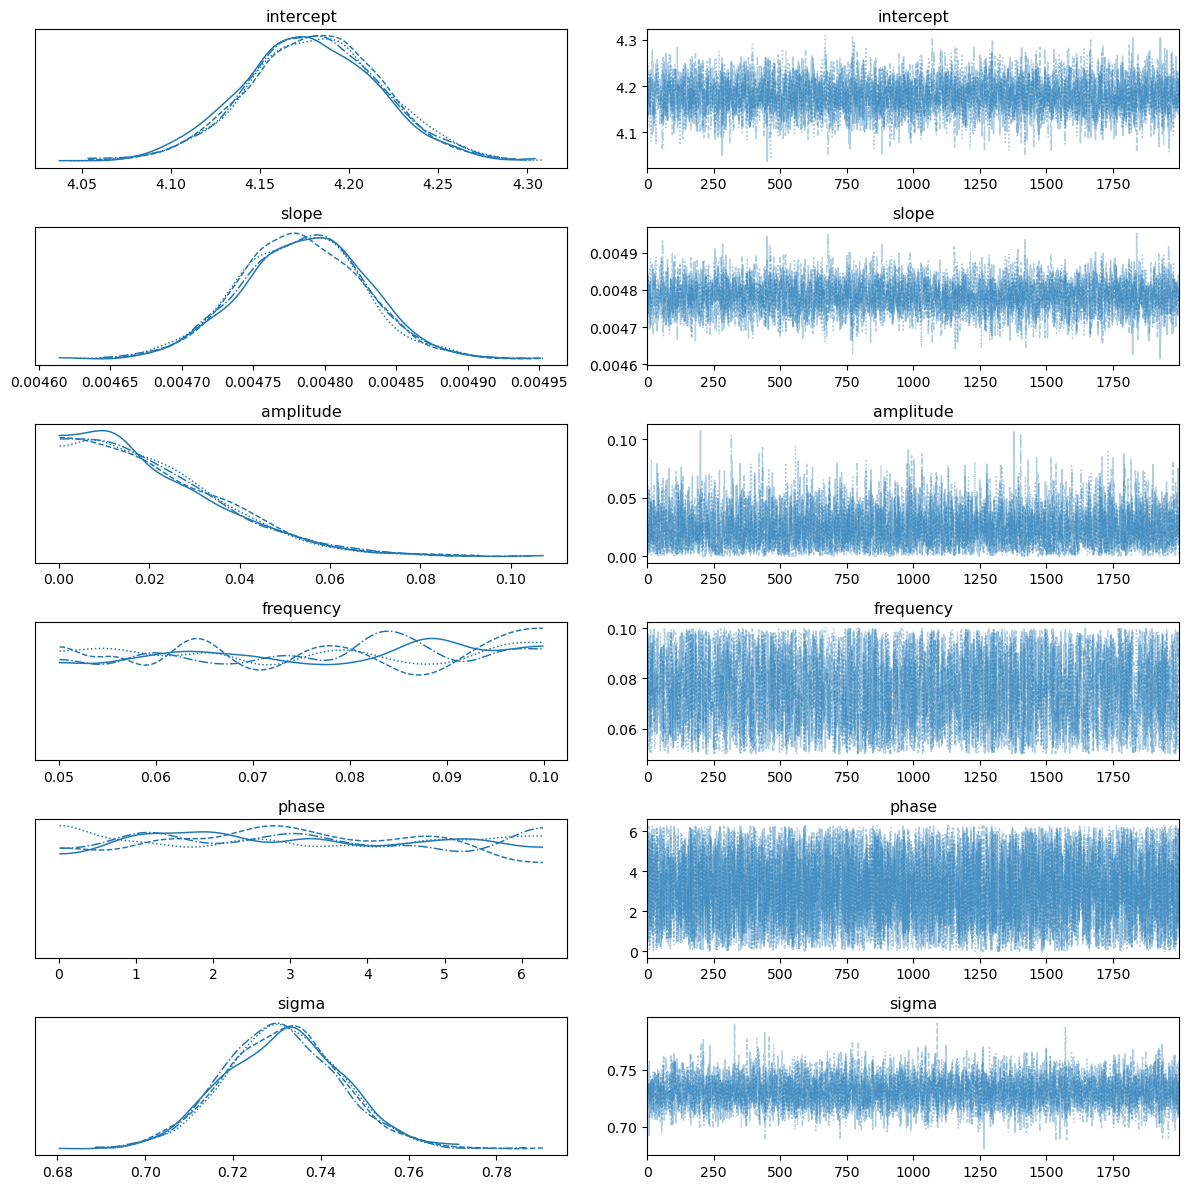

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,4.18,0.04,4.11,4.25,0.00,0.00,3511.29,3716.28,1.0
slope,0.00,0.00,0.00,0.00,0.00,0.00,3503.28,3974.07,1.0
amplitude,0.02,0.02,0.00,0.05,0.00,0.00,3437.47,2738.17,1.0
frequency,0.08,0.01,0.05,0.10,0.00,0.00,3075.21,3239.53,1.0
phase,3.12,1.80,0.04,5.93,0.02,0.02,5904.14,3260.08,1.0
sigma,0.73,0.01,0.71,0.76,0.00,0.00,4952.88,5066.13,1.0


In [12]:
# Plot trace and posterior distributions
az.plot_trace(trace)
plt.tight_layout()
plt.show()
az.summary(trace, round_to=2)

In [13]:
t_future = np.arange(len(train_df)+1, len(df)+1)
posterior = trace.posterior

# Calculate the expected value for the forecast
# Expand dimensions to broadcast properly
intercept_samples = posterior['intercept'].values.flatten()[:, np.newaxis]
slope_samples = posterior['slope'].values.flatten()[:, np.newaxis]
amplitude_samples = posterior['amplitude'].values.flatten()[:, np.newaxis]
frequency_samples = posterior['frequency'].values.flatten()[:, np.newaxis]
phase_samples = posterior['phase'].values.flatten()[:, np.newaxis]
sigma_samples = posterior['sigma'].values.flatten()[:, np.newaxis]

# Compute the mean forecast
mu_forecast = (intercept_samples +
               slope_samples * t_future +
               amplitude_samples * np.sin(2 * np.pi * frequency_samples * t_future + phase_samples))

# Sample noise for the forecast
y_forecast = mu_forecast + np.random.normal(0, sigma_samples, size=mu_forecast.shape)

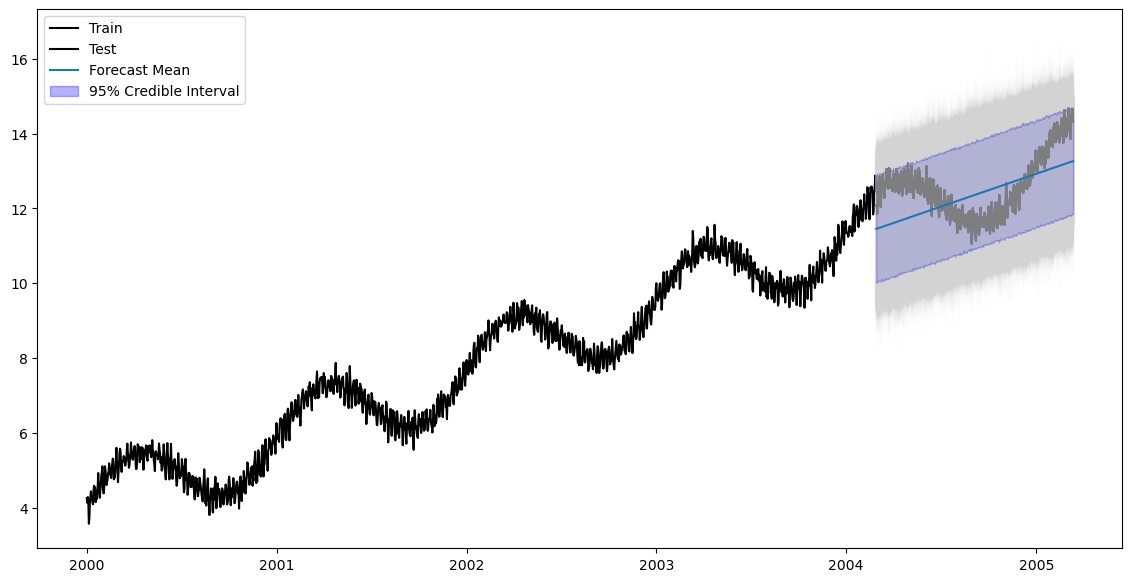

In [14]:
plt.figure(figsize=(14, 7))
plt.plot(train_df, label='Train', color='black')
plt.plot(test_df, label='Test', color='black')

plt.plot(test_df.index, y_forecast.T, color='lightgrey', alpha=0.01)
plt.plot(test_df.index, mu_forecast.mean(axis=0), color='tab:blue', label='Forecast Mean')
lower = np.percentile(y_forecast, 2.5, axis=0)
upper = np.percentile(y_forecast, 97.5, axis=0)
plt.fill_between(test_df.index, lower, upper, color='blue', alpha=0.3, label='95% Credible Interval')
plt.legend()
plt.show()

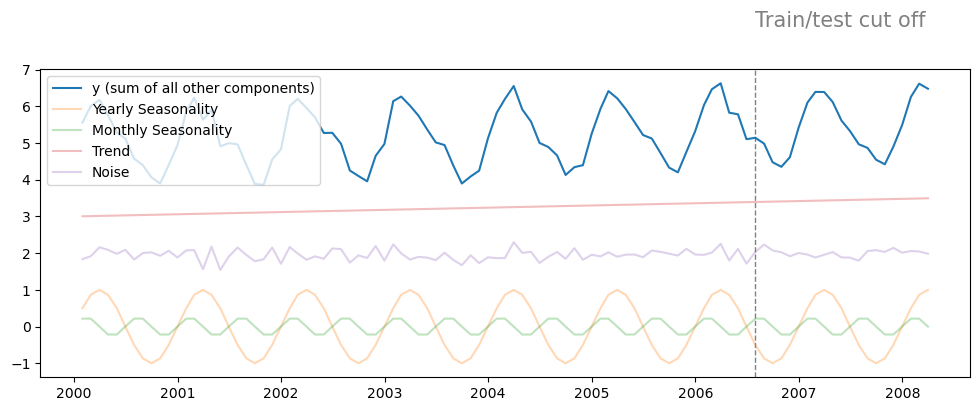

In [15]:
t = np.arange(1, 100)
df = pd.DataFrame({
    'yearly_seasonality': np.sin(2 * np.pi * t / 12),
    'monthly_seasonality': 0.25*np.sin(2*np.pi*t / 12*1550),
    'trend': 3 + t * 0.005,
    'noise': rng.normal(2, scale=0.15, size=len(t)),
},
    index=pd.date_range(start='2000-01-01', periods=len(t), freq='ME')
)
df['total'] = df['yearly_seasonality'] + df['monthly_seasonality'] + df['trend'] + df['noise']

train_cutoff = int(len(df) * 0.8)
target_df = df.loc[:, 'total']
train_df, test_df = target_df.iloc[:train_cutoff], target_df.iloc[train_cutoff:]

def plot_df(df, train_df):
    plt.axvline(x=train_df.index[-1], color='gray', linestyle='--', linewidth=1)
    plt.text(train_df.index[-1], train_df.max()+2, 'Train/test cut off',
        color='gray', fontsize=15, va='top', ha='left')

    plt.plot(df['total'], label='y (sum of all other components)')
    plt.plot(df['yearly_seasonality'], label='Yearly Seasonality', alpha=.3)
    plt.plot(df['monthly_seasonality'], label='Monthly Seasonality', alpha=.3)
    plt.plot(df['trend'], label='Trend', alpha=.3)
    plt.plot(df['noise'], label='Noise', alpha=.3)
    plt.legend()
    plt.show()

plot_df(df, train_df)

In [16]:
# y_test = test_df.values
# y_train = train_df.values
# t_train = np.arange(1, len(train_df)+1)

# with pm.Model() as model:
#     # Priors for the trend
#     intercept = pm.Normal('intercept', mu=5, sigma=10)
#     slope = pm.Normal('slope', mu=0, sigma=1)
    
#     # Priors for seasonality
#     amplitude_1 = pm.HalfNormal('amplitude_1', sigma=10)
#     frequency_1 = pm.Uniform('frequency_1', lower=0.05, upper=.1)  
#     phase_1 = pm.Uniform('phase_1', lower=0, upper=2 * np.pi)

#     amplitude_2 = pm.HalfNormal('amplitude_2', sigma=2)
#     frequency_2 = pm.Uniform('frequency_2', lower=0.05/12, upper=.1/12)  
#     phase_2 = pm.Uniform('phase_2', lower=0, upper=2 * np.pi)
    
#     # Prior for the noise
#     sigma = pm.HalfNormal('sigma', sigma=1)
    
#     # Expected value of the time series
#     mu = intercept + \
#         slope * t_train + \
#         amplitude_1 * pm.math.sin(2 * np.pi * frequency_1 * t_train + phase_1) + \
#         amplitude_2 * pm.math.sin(2 * np.pi * frequency_2 * t_train + phase_2)
    
#     # Likelihood (sampling distribution) of observations
#     y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y_train)

#     trace = pm.sample(
#         draws=2000,
#         tune=1000,
#         nuts={'target_accept': 0.99, 'max_treedepth': 15},
#         return_inferencedata=True
#     )

In [17]:
y_test = test_df.values
y_train = train_df.values
t_train = np.arange(1, len(train_df)+1)

with pm.Model() as model:
    # Priors for the trend
    intercept = pm.Normal('intercept', mu=4, sigma=10)
    slope = pm.Normal('slope', mu=0, sigma=1)
    
    # Priors for seasonality
    amplitude_1 = pm.HalfNormal('amplitude_1', sigma=10)
    frequency_1 = pm.Uniform('frequency_1', lower=0.05, upper=.1)  
    phase_1 = pm.Uniform('phase_1', lower=0, upper=2 * np.pi)

    amplitude_2 = pm.HalfNormal('amplitude_2', sigma=2)
    frequency_2 = pm.Uniform('frequency_2', lower=0.05/12, upper=.1/12)  
    phase_2 = pm.Uniform('phase_2', lower=0, upper=2 * np.pi)
    
    # Prior for the noise
    sigma = pm.HalfNormal('sigma', sigma=1)
    
    # Expected value of the time series
    mu = intercept + \
        slope * t_train + \
        amplitude_1 * pm.math.sin(2 * np.pi * frequency_1 * t_train + phase_1) + \
        amplitude_2 * pm.math.sin(2 * np.pi * frequency_2 * t_train + phase_2)
    
    # Likelihood (sampling distribution) of observations
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y_train)

    trace = pm.sample(
        draws=2000,
        tune=1000,
        nuts={'target_accept': 0.99, 'max_treedepth': 15},
        return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, amplitude_1, frequency_1, phase_1, amplitude_2, frequency_2, phase_2, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 118 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


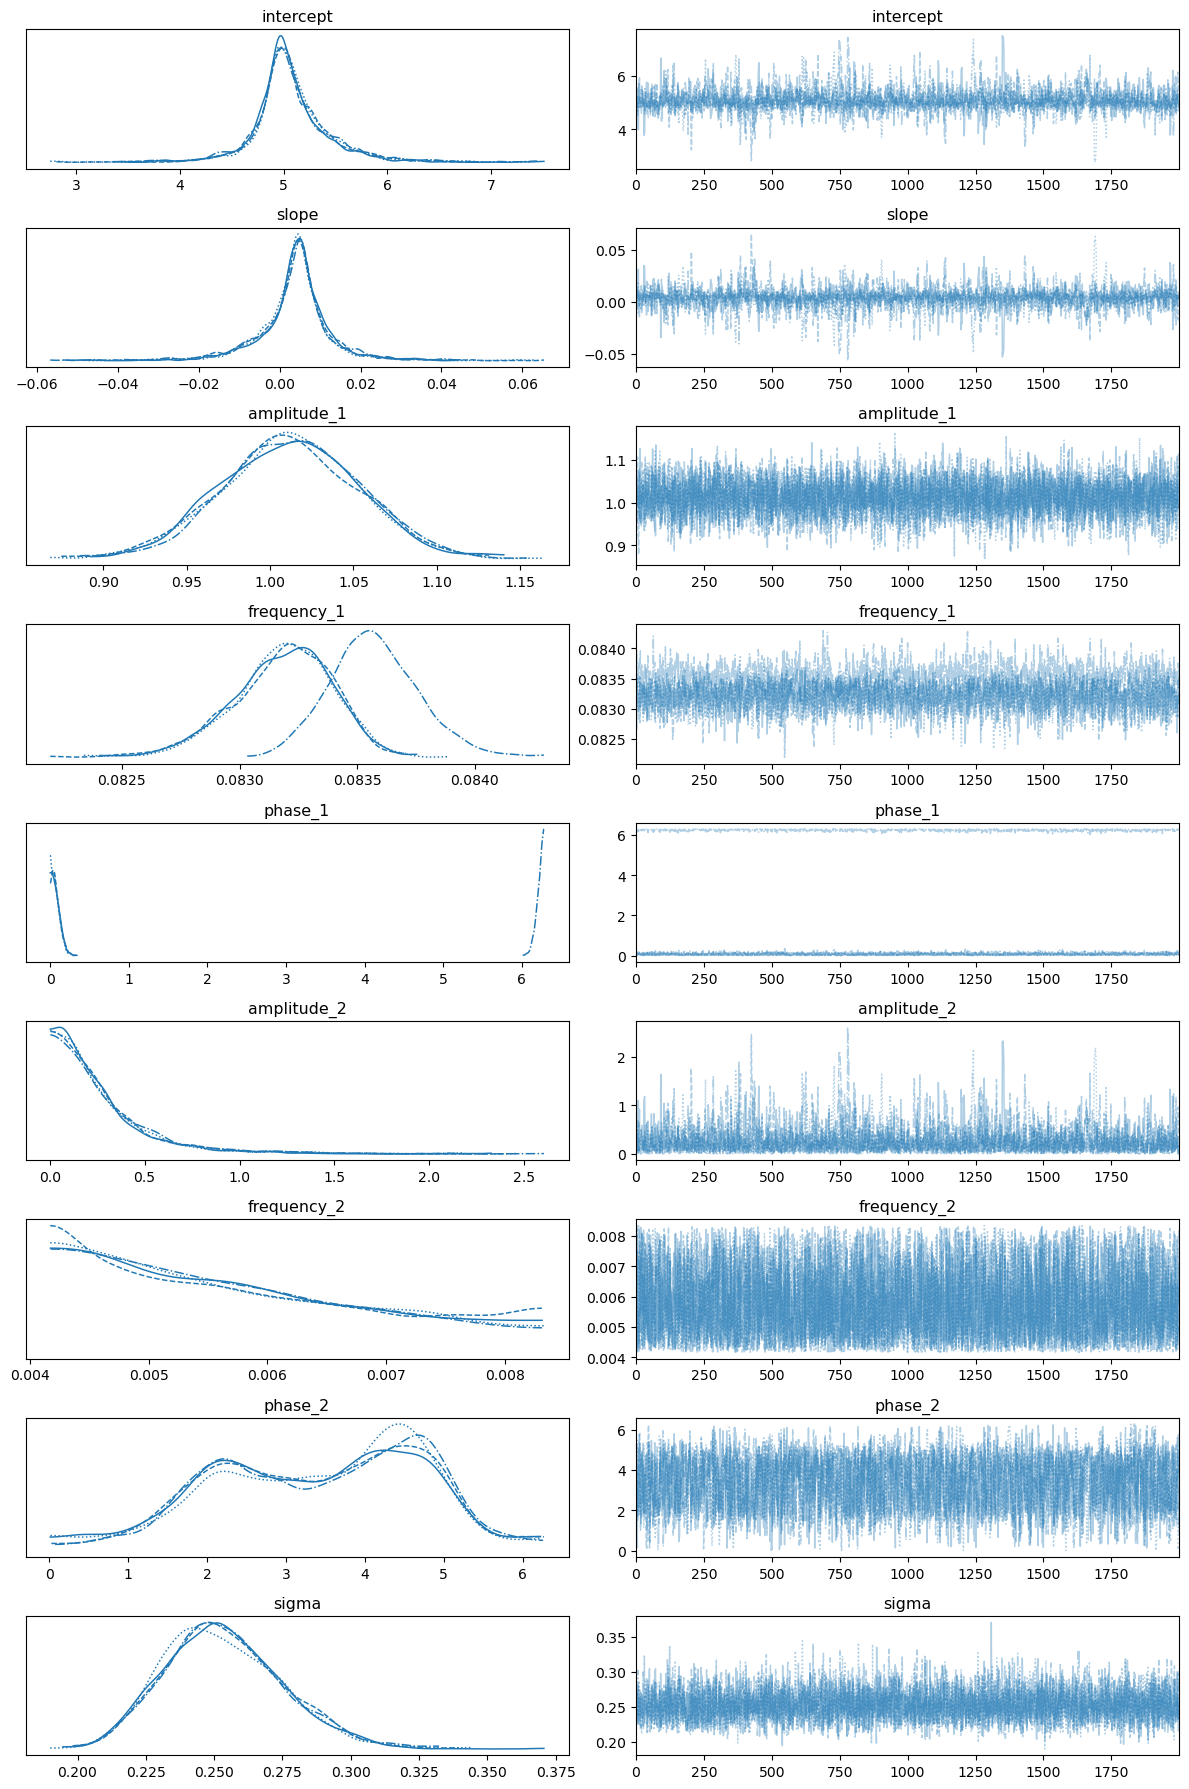

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,5.08,0.39,4.36,5.86,0.01,0.01,1548.68,1652.16,1.00
slope,0.00,0.01,-0.01,0.02,0.00,0.00,1493.50,1673.42,1.00
amplitude_1,1.01,0.04,0.94,1.09,0.00,0.00,5837.27,4822.62,1.00
frequency_1,0.08,0.00,0.08,0.08,0.00,0.00,9.52,31.91,1.33
phase_1,1.61,2.66,0.00,6.26,1.33,1.02,7.15,28.94,1.53
amplitude_2,0.27,0.28,0.00,0.74,0.01,0.01,1916.07,2100.31,1.00
frequency_2,0.01,0.00,0.00,0.01,0.00,0.00,4646.89,4205.10,1.00
phase_2,3.40,1.31,0.98,5.53,0.03,0.02,2604.69,3427.53,1.00
sigma,0.25,0.02,0.21,0.29,0.00,0.00,5546.74,4631.32,1.00


In [18]:
# Plot trace and posterior distributions
az.plot_trace(trace)
plt.tight_layout()
plt.show()
az.summary(trace, round_to=2)

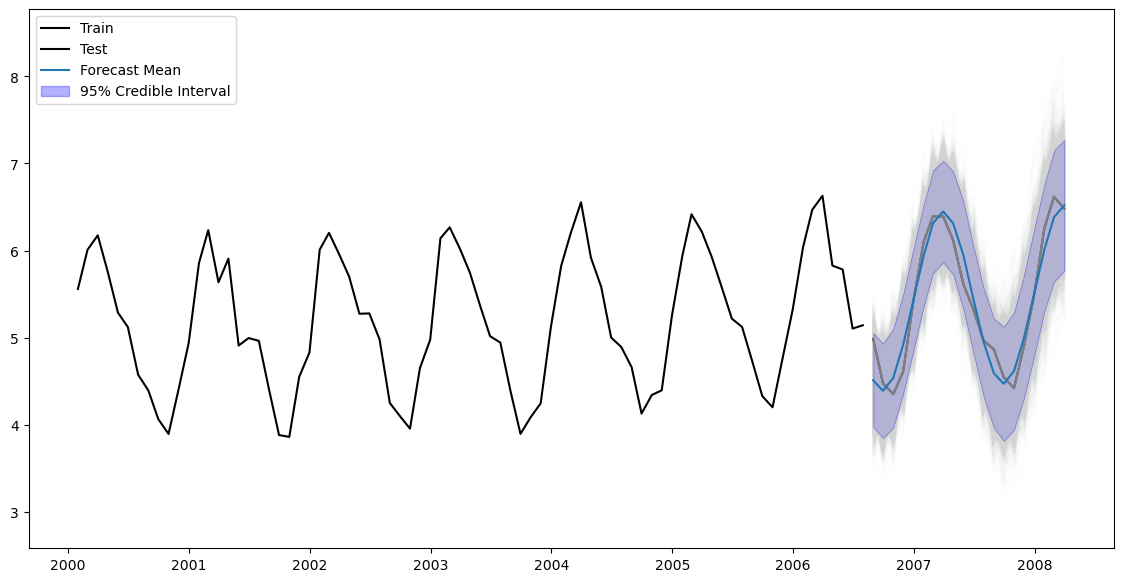

In [19]:
t_future = np.arange(len(train_df)+1, len(df)+1)
posterior = trace.posterior

# Calculate the expected value for the forecast
# Expand dimensions to broadcast properly
intercept_samples = posterior['intercept'].values.flatten()[:, np.newaxis]
slope_samples = posterior['slope'].values.flatten()[:, np.newaxis]
amplitude_1_samples = posterior['amplitude_1'].values.flatten()[:, np.newaxis]
frequency_1_samples = posterior['frequency_1'].values.flatten()[:, np.newaxis]
phase_1_samples = posterior['phase_1'].values.flatten()[:, np.newaxis]
amplitude_2_samples = posterior['amplitude_2'].values.flatten()[:, np.newaxis]
frequency_2_samples = posterior['frequency_2'].values.flatten()[:, np.newaxis]
phase_2_samples = posterior['phase_2'].values.flatten()[:, np.newaxis]
sigma_samples = posterior['sigma'].values.flatten()[:, np.newaxis]

# Compute the mean forecast
mu_forecast = (intercept_samples +
               slope_samples * t_future +
               amplitude_1_samples * np.sin(2 * np.pi * frequency_1_samples * t_future + phase_1_samples) + 
               amplitude_2_samples * np.sin(2 * np.pi * frequency_2_samples * t_future + phase_2_samples))

# Sample noise for the forecast
y_forecast = mu_forecast + np.random.normal(0, sigma_samples, size=mu_forecast.shape)

plt.figure(figsize=(14, 7))
plt.plot(train_df, label='Train', color='black')
plt.plot(test_df, label='Test', color='black')

plt.plot(test_df.index, y_forecast.T, color='lightgrey', alpha=0.01)
plt.plot(test_df.index, mu_forecast.mean(axis=0), color='tab:blue', label='Forecast Mean')
lower = np.percentile(y_forecast, 2.5, axis=0)
upper = np.percentile(y_forecast, 97.5, axis=0)
plt.fill_between(test_df.index, lower, upper, color='blue', alpha=0.3, label='95% Credible Interval')
plt.legend()
plt.show()

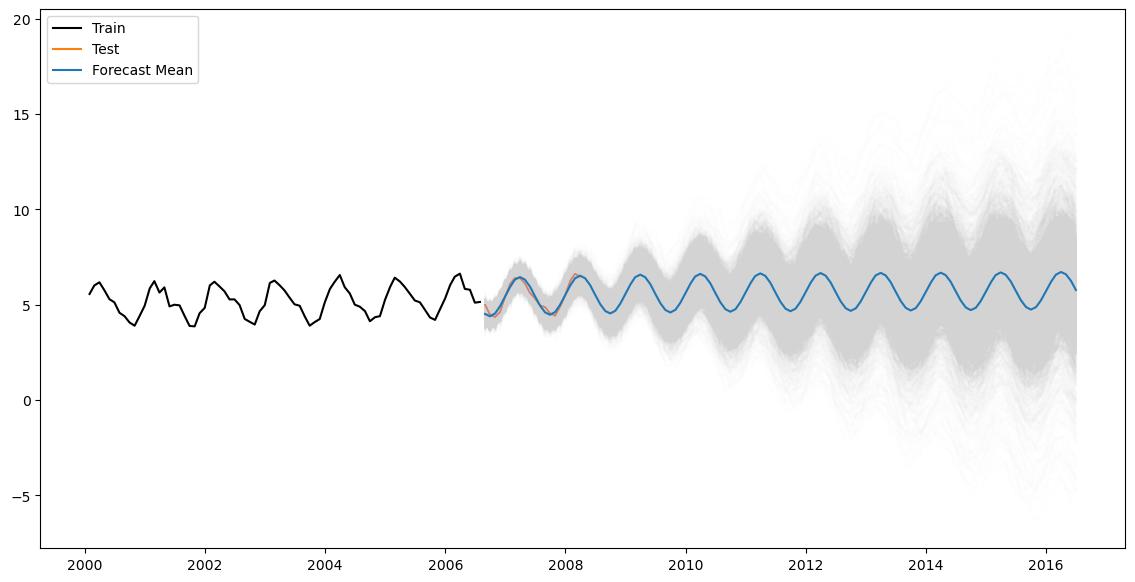

In [30]:
t_future = np.arange(len(train_df)+1, len(df)+100)
posterior = trace.posterior

# Calculate the expected value for the forecast
# Expand dimensions to broadcast properly
sigma_samples = posterior['sigma'].values.flatten()[:, np.newaxis]
intercept_samples = posterior['intercept'].values.flatten()[:, np.newaxis]
slope_samples = posterior['slope'].values.flatten()[:, np.newaxis]

amplitude_1_samples = posterior['amplitude_1'].values.flatten()[:, np.newaxis]
frequency_1_samples = posterior['frequency_1'].values.flatten()[:, np.newaxis]
phase_1_samples = posterior['phase_1'].values.flatten()[:, np.newaxis]

amplitude_2_samples = posterior['amplitude_2'].values.flatten()[:, np.newaxis]
frequency_2_samples = posterior['frequency_2'].values.flatten()[:, np.newaxis]
phase_2_samples = posterior['phase_2'].values.flatten()[:, np.newaxis]

# Compute the mean forecast
mu_forecast = (intercept_samples +
               slope_samples * t_future +
               amplitude_1_samples * np.sin(2 * np.pi * frequency_1_samples * t_future + phase_1_samples) + 
               amplitude_2_samples * np.sin(2 * np.pi * frequency_2_samples * t_future + phase_2_samples))

# Sample noise for the forecast
y_forecast = mu_forecast + np.random.normal(0, sigma_samples, size=mu_forecast.shape)

plt.figure(figsize=(14, 7))
plt.plot(train_df, label='Train', color='black')
plt.plot(test_df, label='Test', color='tab:orange')
plt.plot(pd.date_range(start=test_df.index[0], periods=len(t_future), freq='ME'), y_forecast.T, color='lightgrey', alpha=0.01)
plt.plot(pd.date_range(start=test_df.index[0], periods=len(t_future), freq='ME'), mu_forecast.mean(axis=0), color='tab:blue', label='Forecast Mean')
plt.legend()
plt.show()